### IMBH Forecast

TODO:
- obscured fraction
- dust extinction/reddening effects
- 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle
from taufit import simulate_from_psd, smoothly_broken_power_law, fit_drw

from tqdm.notebook import tqdm

import scipy.stats as st

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

In [2]:
from model import DemographicModel, ERDF

In [3]:
def set_mpl_style():
    
    """Function to set MPL style"""
    
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 1.8
    lhandle = 2.0
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [4]:
set_mpl_style()

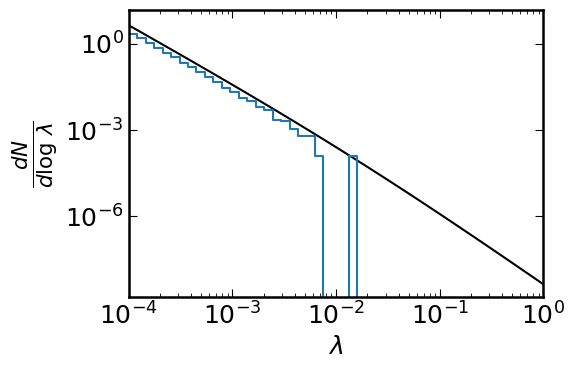

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

l = np.logspace(-4, 0, 100)
dlogl = np.diff(np.log10(l))[0]
p = ERDF(l)*dlogl
p = p/np.sum(p)
s = np.random.choice(l, 100000, p=p)

ax.loglog(l, p/dlogl, c='k')

bins = np.logspace(-4, 0, 50)
h, bin_edges = np.histogram(s, bins=bins)
ax.step(bin_edges[:-1], h/np.diff(np.log10(bins))[0]/len(s))

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel(r'$\frac{dN}{d\log\ \lambda}$', fontsize=22)

ax.tick_params('both', labelsize=18)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlim(1e-4, 1e0)

fig.tight_layout()

### Load previous model instance

In [6]:
## OK, we may need to cut off the upper-mass end to save memory...

In [58]:
model_ptf = DemographicModel()
model_lsst = DemographicModel()

#model.sample(nbins=16, nbootstrap=20, zmax=0.15, eta=1, ndraw_dim=1e10) #eta=1e3
#model_ptf.sample(nbins=16, nbootstrap=5, zmax=0.055, eta=1e2, ndraw_dim=1e8, k_X=20) #eta=1e3

model_ptf.sample(nbins=16, nbootstrap=5, zmax=0.055, eta=1e1, ndraw_dim=1e7, k_X=20)
model_lsst.sample(nbins=16, nbootstrap=5, zmax=0.055, eta=1e1, ndraw_dim=1e7, k_X=20)

  0%|          | 0/5 [00:00<?, ?it/s]

3972658
6165543
2893421
3415739
3966393


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


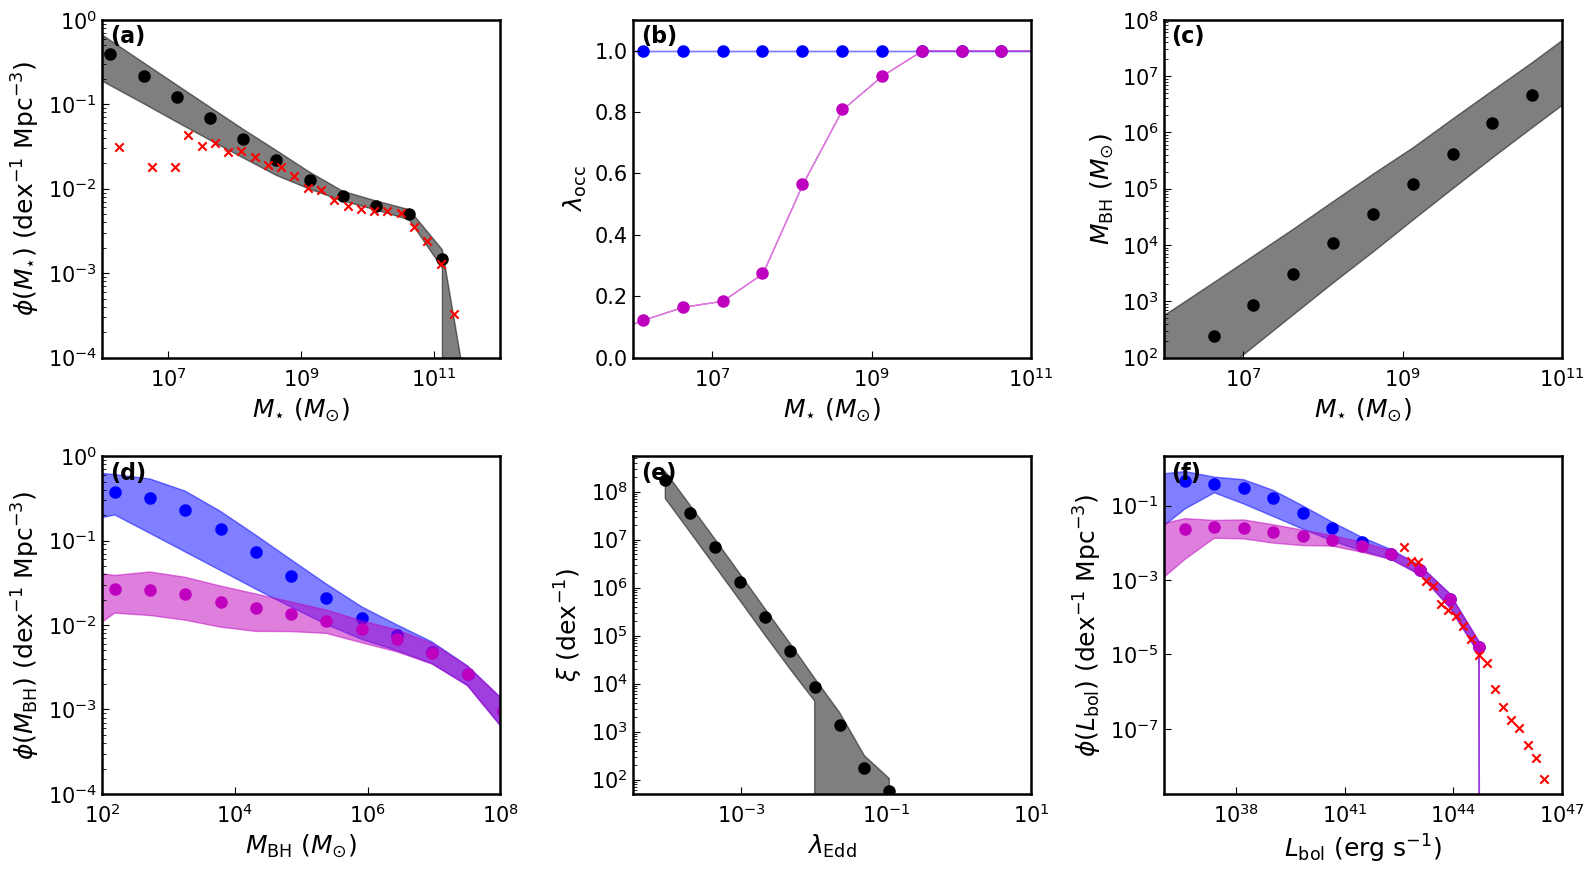

In [8]:
fig_ptf = model_ptf.plot()
#fig_lsst = model_lsst.plot()

fig_ptf.savefig('model.pdf', dpi=300)

Shouldnt we use the mag of host + AGN? Why is that giving significantly different results?

In [ ]:
bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g'}

model_ptf.sample_sed_grid(band=bands['ptf'])
model_lsst.sample_sed_grid(band=bands['lsst'])

Setting up model SED
Creating SED grid in band SDSS_g


### Mock Observations: light curves

PTF:

In [11]:
num_seasons = 5
season_duration = 95 # days
cadence = 5 # days
t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
t_obs = np.array(t_obs).flatten()

model_ptf.sample_light_curves(t_obs, band=bands['ptf'], dt_min=cadence)

(5, 8310767)
Sampling light curves with seeding mechanism dc


  0%|          | 0/5 [00:00<?, ?it/s]

Sampling light curves with seeding mechanism popIII


  0%|          | 0/5 [00:00<?, ?it/s]

/home/colinjb2/forecast/model.py:142: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9) + np.random.normal(0, 0.09, size=len(M_BH))) # Delta mag
/home/colinjb2/forecast/model.py:150: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9)) # Delta mag
/home/colinjb2/forecast/model.py:162: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e8) + np.random.normal(0, 0.09, size=size)) # days


LSST:

In [ ]:
num_seasons = 10
season_duration = 95 # days
cadence = 3 # days
t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
t_obs = np.array(t_obs).flatten()

model_lsst.sample_light_curves(t_obs, band=bands['lsst'], dt_min=cadence)

In [12]:
pars = {'ptf':model_ptf.pars, 'lsst':model_lsst.pars}

samples = {'ptf':model_ptf.samples, 'lsst':model_lsst.samples}

#np.save('s_lsst.npy', s_lsst)
#np.save('s_ptf.npy', s_ptf)

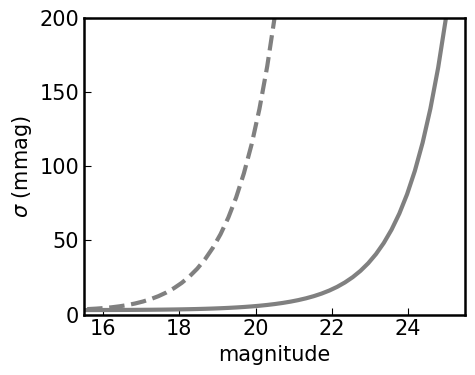

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

m_eval = np.linspace(15, 25)
m_5 = {'ptf':20.5, 'lsst':25.0}
gamma = {'ptf':0.04, 'lsst':0.038}

def pm_prec(mag, gamma=0.038, m_5=25.0, sigma_sys=0.003):
    x = 10**(0.4*(mag - m_5))
    sigma_rand = np.sqrt((0.04 - gamma)*x + gamma*x**2)
    return np.sqrt(sigma_sys**2 + sigma_rand**2)

pm_prec_lsst = pm_prec(m_eval, gamma=gamma['lsst'], m_5=m_5['lsst'])
pm_prec_ptf = pm_prec(m_eval, gamma=gamma['ptf'], m_5=m_5['ptf'])

ax.plot(m_eval, 1e3*pm_prec_lsst, color='gray', lw=3)
ax.plot(m_eval, 1e3*pm_prec_ptf, color='gray', lw=3, linestyle='dashed')

ax.set_xlim(15.5, 25.5)
ax.set_ylim(0, 200)
ax.set_ylabel(r'$\sigma$ (mmag)')
ax.set_xlabel(r'magnitude')

fig.tight_layout()
fig.savefig('phprec.pdf', dpi=300)

In [14]:
def calc_sigma_var(mag, magerr):
    
    N = np.shape(mag)[0] # Number of light curves
    nu = np.shape(mag)[1] - 1
    
    wt = 1/magerr**2
    m0 = np.sum(mag*wt, axis=1)/np.sum(wt, axis=1)
    m0 = np.array([m0]*(nu+1)).T # Reshape
        
    chisq = 1/nu*np.sum((mag - m0)**2*wt, axis=1)
    
    p = st.chi2.sf(chisq, nu) #1 - cdf
    
    log_p = np.log(p)
    
    sigma_var = np.zeros_like(p)
    
    mask_small = (log_p > -36)
    
    sigma_var[mask_small] = st.norm.ppf(1 - p[mask_small]/2)
    sigma_var[~mask_small] = np.sqrt(np.log(2/np.pi) - 2*np.log(8.2) - 2*log_p[~mask_small])
    
    return sigma_var

In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from qsofit import qso_fit

for k, (key, s) in enumerate(samples.items()):
    
    band = bands[key]

    nbootstrap = pars[key]['nbootstrap']
    ndraw_dim = int(np.max(s['ndraws']))

    for i, seed in enumerate(['dc','popIII']):

        s[f'sigma_var_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'sigma_vary_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'sigma_qso_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            # Get magnitudes
            mag = s[f'lc_{band}_{seed}_{j}']
            # Get uncertainties from photometric precision model
            magerr = pm_prec(mag, gamma=gamma[key], m_5=m_5[key])
            # Calculate variability significance
            indx = s[f'lc_{band}_{seed}_idx'][j,:ndraw]
            indx = indx[np.isfinite(indx)].astype(np.int)
            s[f'sigma_var_{seed}'][j,indx] = calc_sigma_var(mag, magerr)
            #qso = qso_fit(t_obs, mag, magerr)
            #s[f'sigma_qso_{seed}'][j,indx] = qso['signif_qso']
            #s[f'sigma_vary_{seed}'][j,indx] = qso['signif_vary']

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [17]:
np.any(s[f'sigma_var_{seed}']>3)

True

In [ ]:
mask = (samples['ptf'][f'sigma_var_popIII'] > 3)
mag = samples['ptf'][f'lc_{band}_{seed}'][mask][0]

#pm_prec(m_eval, gamma=gamma['ptf'], m_5=m_5['ptf'])

plt.errorbar(t_obs, mag, yerr=magerr)
#calc_sigma_var(np.array([mag]), np.array([pm_prec(mag)]))

In [21]:
s.keys()

dict_keys(['zmax', 'zmin', 'M_star_draw', 'M_star_draw_test', 'n_i_M', 'z_draw', 'M_BH_draw', 'M_BH_draw_dc', 'n_i_M_dc', 'M_BH_draw_popIII', 'n_i_M_popIII', 'lambda_draw', 'n_i_Edd', 'L_draw_dc', 'n_i_L_dc', 'L_draw_popIII', 'n_i_L_popIII', 'ndraws', 'L_SDSS_g_model', 'M_i_model', 'L_SDSS_g_dc', 'M_i_dc', 'L_SDSS_g_popIII', 'M_i_popIII', 'lc_t_obs', 'lc_SDSS_g_dc', 'm_SDSS_g_dc', 'SFinf_SDSS_g_dc', 'tau_RF_SDSS_g_dc', 'L_host_SDSS_g_dc', 'lc_SDSS_g_popIII', 'm_SDSS_g_popIII', 'SFinf_SDSS_g_popIII', 'tau_RF_SDSS_g_popIII', 'L_host_SDSS_g_popIII', 'sigma_var'])

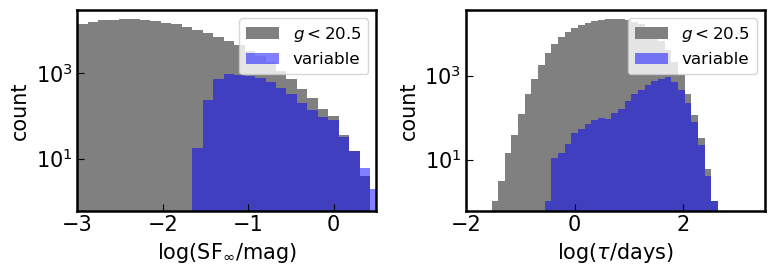

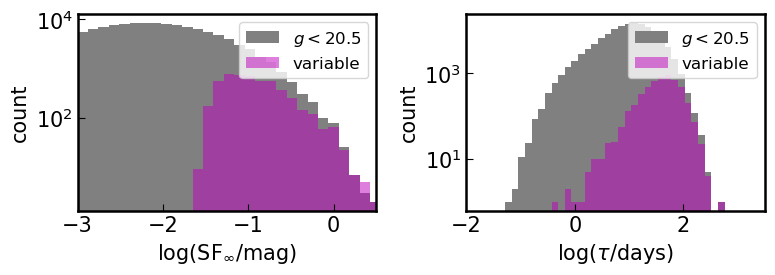

In [18]:
key = 'ptf'
s = samples[key]
nbootstrap = pars[key]['nbootstrap']

colors = ['b','m']

for j in range(1): ## Just use the first bootstrap

    for i, seed in enumerate(['dc','popIII']):

        fig, axs = plt.subplots(1, 2, figsize=(8, 3))

        bins = np.linspace(-3, 3)

        ndraw_dim = int(np.max(s['ndraws']))
        ndraw = int(s['ndraws'][j])
        
        SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim]
        tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim]

        mask_nan = np.isfinite(SF) & np.isfinite(tau)
        mask_mass = s['M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
        #mask_tau = tau > 3
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 3
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > 14


        axs[0].hist(np.log10(SF[mask_mass & mask_mag & mask_sat]), bins=bins, color='gray', label=fr'$g<{m_5[key]}$', log=True)
        axs[0].hist(np.log10(SF[mask_mass & mask_var & mask_sat]), bins=bins, color=colors[i], label='variable', alpha=0.5)

        axs[0].set_xlim(-3, 0.5)
        ax.set_ylim(0, 1500)

        axs[0].set_xlabel(r'$\log(\rm{SF}_{\infty} / {\rm{mag}})$')
        axs[0].set_ylabel(r'count')

        axs[0].legend(fontsize=12)


        bins = np.linspace(-3, 3)

        axs[1].hist(np.log10(tau[mask_mass & mask_mag & mask_sat]), bins=bins, color='gray', label=fr'$g<{m_5[key]}$', log=True)
        axs[1].hist(np.log10(tau[mask_mass & mask_var & mask_sat]), bins=bins, color=colors[i], label='variable', alpha=0.5)
        axs[1].set_xlim(-2.0, 3.5)

        axs[1].set_xlabel(r'$\log(\tau / {\rm{days}})$')
        axs[1].set_ylabel(r'count')


        axs[1].legend(fontsize=12, loc='upper right')

        fig.tight_layout()
        fig.savefig(f'var_{seed}.pdf', dpi=300)


In [55]:
np.any(SF)

True

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


ValueError: supplied range of [-inf, 43.72093539904796] is not finite

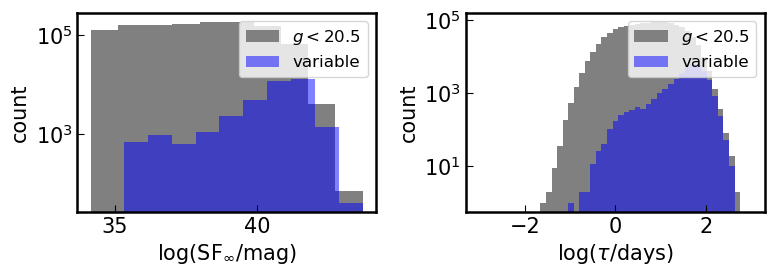

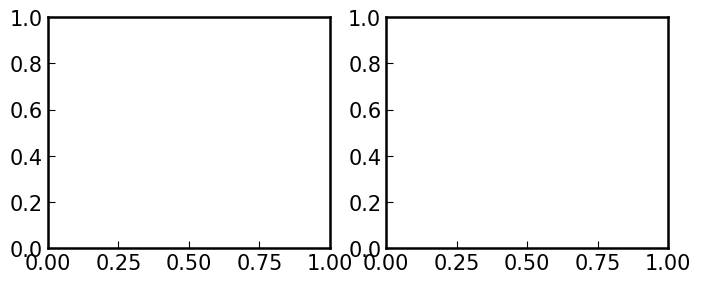

In [57]:
key = 'ptf'
s = samples[key]
nbootstrap = pars[key]['nbootstrap']

colors = ['b','m']

for j in range(1): ## Just use the first bootstrap

    for i, seed in enumerate(['dc','popIII']):

        fig, axs = plt.subplots(1, 2, figsize=(8, 3))

        bins = np.linspace(-3, 3)

        ndraw_dim = int(np.max(s['ndraws']))
        ndraw = int(s['ndraws'][j])
        
        SF = s[f'L_{band}_{seed}'][j,:ndraw_dim].value
        tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim]

        mask_mass = s['M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
        #mask_tau = tau > 3
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 3
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > 14


        axs[0].hist(np.log10(SF[mask_mass & mask_mag & mask_sat]), color='gray', label=fr'$g<{m_5[key]}$', log=True)
        axs[0].hist(np.log10(SF[mask_mass & mask_var & mask_sat]), color=colors[i], label='variable', alpha=0.5)

        #axs[0].set_xlim(-3, 0.5)
        #ax.set_ylim(0, 1500)

        axs[0].set_xlabel(r'$\log(\rm{SF}_{\infty} / {\rm{mag}})$')
        axs[0].set_ylabel(r'count')

        axs[0].legend(fontsize=12)


        bins = np.linspace(-3, 3)

        axs[1].hist(np.log10(tau[mask_mass & mask_mag & mask_sat]), bins=bins, color='gray', label=fr'$g<{m_5[key]}$', log=True)
        axs[1].hist(np.log10(tau[mask_mass & mask_var & mask_sat]), bins=bins, color=colors[i], label='variable', alpha=0.5)
        #axs[1].set_xlim(-2.0, 3.5)

        axs[1].set_xlabel(r'$\log(\tau / {\rm{days}})$')
        axs[1].set_ylabel(r'count')


        axs[1].legend(fontsize=12, loc='upper right')

        fig.tight_layout()
        fig.savefig(f'var_{seed}.pdf', dpi=300)


In [ ]:
mask_mag = s[f'm_{band}_{seed}'] < 25

z = s['z_draw'][mask_mass & mask_var]
plt.scatter(np.log10(s[f'SFinf_{band}_{seed}'][mask_mass & mask_var]),
            np.log10(s[f'tau_RF_{band}_{seed}'][mask_mass & mask_var]*(1 + z)),
            color='red', s=1, zorder=1)
z = s['z_draw'][mask_mass & mask_mag]
plt.scatter(np.log10(s[f'SFinf_{band}_{seed}'][mask_mass & mask_mag]),
            np.log10(s[f'tau_RF_{band}_{seed}'][mask_mass & mask_mag]*(1 + z)),
            color='gray', s=.01, zorder=0)
plt.gca().set_xlim(-3, 0.0)

# Why the large tau branch?

# OK, try bumping up stellar mass and BH mass to 1e13

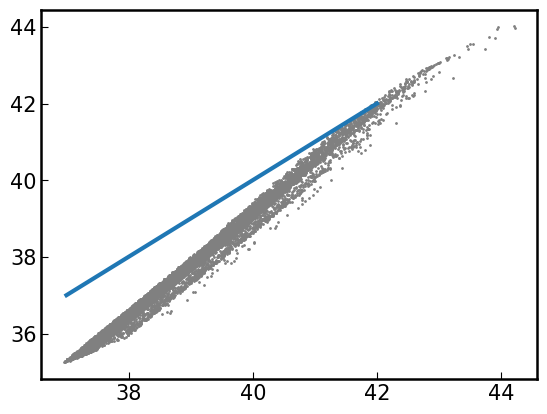

In [86]:
plt.scatter(np.log10(s[f'L_draw_popIII'][mask_mass & mask_mag].value), np.log10(s[f'L_{band}'][mask_mass & mask_mag].value),
            color='gray', s=1)
#plt.scatter(np.log10(s[f'L_draw_popIII'][mask_mass & mask_var].value), np.log10(s[f'L_{band}'][mask_mass & mask_var].value),
#            color='red', s=.01)
plt.plot([37, 42], [37, 42], lw=3)

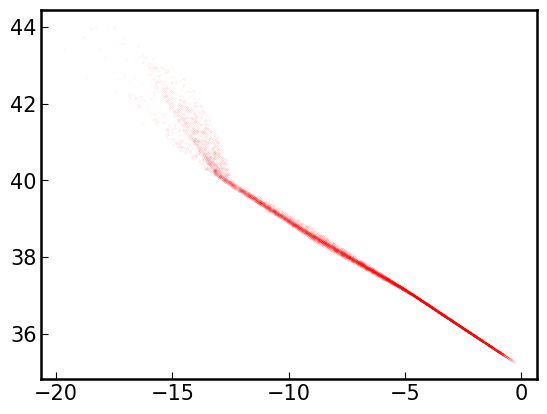

In [87]:
plt.scatter(s[f'M_i'][mask_mass & mask_mag], np.log10(s[f'L_{band}'][mask_mass & mask_mag].value), color='red', s=.001)

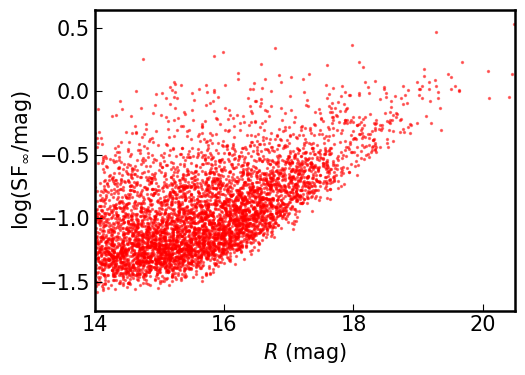

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

key = 'ptf'
s = samples[key]
nbootstrap = pars[key]['nbootstrap']


for j in range(1): ## Just use the first bootstrap
    
    ndraw_dim = int(np.max(s['ndraws']))

    mask_mass = s['M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
    #mask_tau = tau > 3
    mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
    #mask_sat
    mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 3
    mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > 14

    ax.scatter(samples['ptf'][f'm_{band}_{seed}'][j,:][mask_mass & mask_var],#, & mask_sat],
               np.log10(samples['ptf'][f'SFinf_{band}_{seed}'][j,:][mask_mass & mask_var]),# & mask_sat]),
               color='red', s=2, zorder=1, alpha=0.5)

    
ax.set_xlim([14, m_5[key]])
ax.set_ylabel(r'$\log(\rm{{SF}}_{\infty} / {\rm{mag}})$')
ax.set_xlabel(r'$R$ (mag)')
fig.tight_layout()

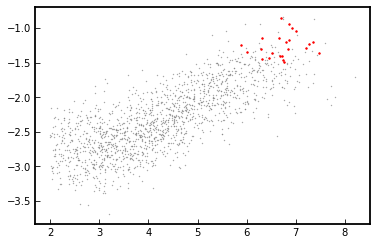

In [38]:
# This doesnt look like what I put in!
plt.scatter(np.log10(s[f'M_BH_draw'][mask_mass & mask_var].value),
            np.log10(s[f'SFinf_{band}_{seed}'][mask_mass & mask_var]),
            color='red', s=2, zorder=1)
plt.scatter(np.log10(s[f'M_BH_draw'][mask_mass & mask_mag].value),
            np.log10(s[f'SFinf_{band}_{seed}'][mask_mass & mask_mag]),
            color='gray', s=0.1, zorder=0)

In [28]:
mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
np.any(~np.isfinite(s[f'm_{band}_{seed}'][j,:ndraw_dim][mask_mass]))

False

dc


No handles with labels found to put in legend.


popIII


No handles with labels found to put in legend.


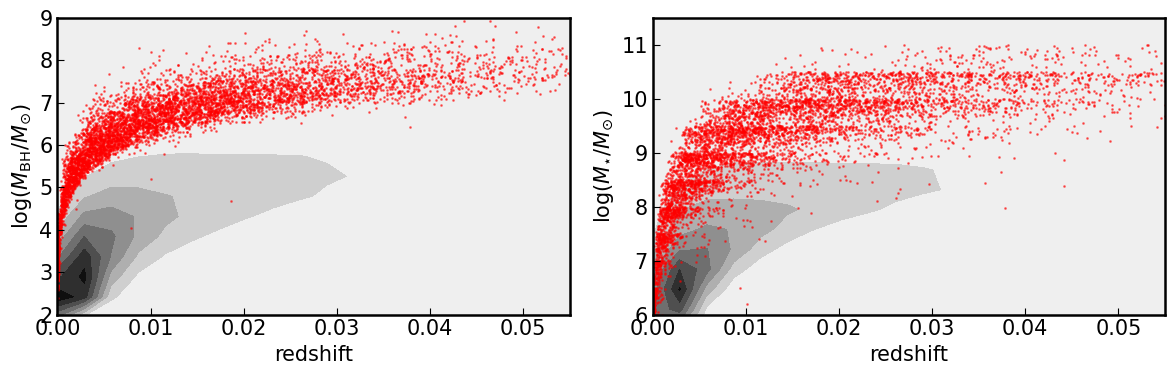

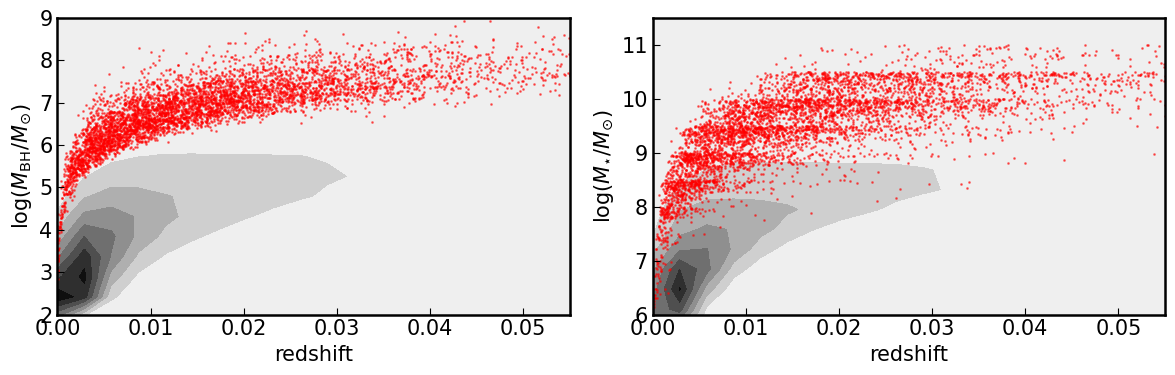

In [20]:
key = 'ptf'
s = samples[key]
nbootstrap = pars[key]['nbootstrap']


for j in range(1): ## Just use the first bootstrap
    
    for i, seed in enumerate(['dc','popIII']):
        
        fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
        
        print(seed)
    
        ndraw_dim = int(np.max(s['ndraws']))

        mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
        mask_mass_all = s[f'M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > 14
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 3

        x = s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
        y = np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_mag & mask_sat]

        # Peform the kernel density estimate
        xx, yy = np.mgrid[0:s['zmax']:20j, 1:10:20j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        # Contourf plot
        cfset = axs[0].contourf(xx, yy, f, cmap='binary')

        #axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_sat],
        #               np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_sat],
        #               color='gray', s=1, zorder=5)
        
        axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                       np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass & mask_var & mask_sat],
                       color='r', alpha=0.5, s=1)

        axs[0].set_ylim(2, 9)
        #axs[0].set_xlim(0, s['zmax'])
        axs[0].set_xlabel(r'redshift')
        axs[0].set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')

        x = s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
        y = np.log10(s[f'M_star_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_mag & mask_sat]

        # Peform the kernel density estimate
        xx, yy = np.mgrid[0:s['zmax']:20j, 5:12:20j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        cfset = axs[1].contourf(xx, yy, f, cmap='binary')

        axs[1].scatter(s['z_draw'][j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                       np.log10(s[f'M_star_draw'][j,:ndraw_dim].value)[mask_mass & mask_var & mask_sat],
                       color='r', alpha=0.5, s=1)

        axs[1].set_ylim(6, 11.5)
        #axs[1].set_xlim(0, s['zmax'])
        #axs[1].set_yscale('log')
        axs[1].set_xlabel(r'redshift')
        axs[1].set_ylabel(r'$\log(M_{\star}/M_{\odot})$')

        ax.legend(fontsize=12)

        fig.tight_layout()

In [ ]:
## WHy is this not a perfectly straight line?

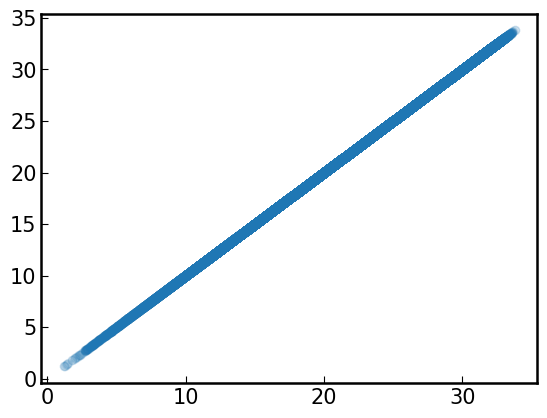

In [56]:
# Gray area in M_star should be identical between seed
plt.scatter(s[f'm_host_{band}_popIII'][::10000], s[f'm_host_{band}_dc'][::10000], alpha=0.1)

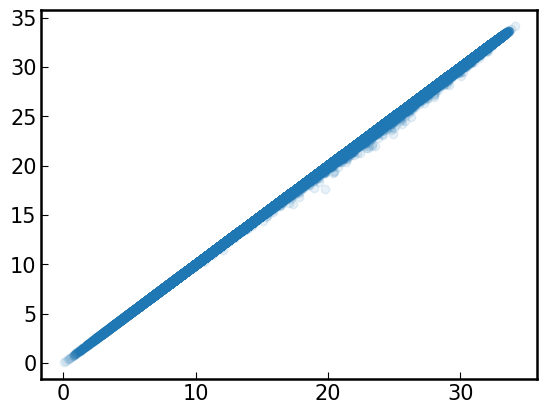

In [57]:
plt.scatter(s[f'm_{band}_popIII'], s[f'm_{band}_dc'], alpha=0.1)

In [21]:
# stellar mass distribution should not change

In [ ]:
# plot histogram of bolometric luminsities with var > 3

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


[1879. 2365. 1777.  758.  204.   49.   10.]
[1620. 1944. 1532.  628.  171.   46.   15.]
[2144. 2757. 2059.  946.  238.   57.   18.]
[9.900e+02 1.149e+03 8.140e+02 2.900e+02 8.100e+01 2.000e+01 1.000e+00]
[502. 609. 380. 100.  18.   3.   0.]


/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


[1539. 1877. 1413.  572.  131.   30.    6.]
[1188. 1337. 1065.  408.  101.   19.    8.]
[1611. 1962. 1501.  673.  153.   38.   15.]
[882. 991. 680. 228.  42.  11.   1.]
[510. 569. 381.  96.  16.   3.   0.]


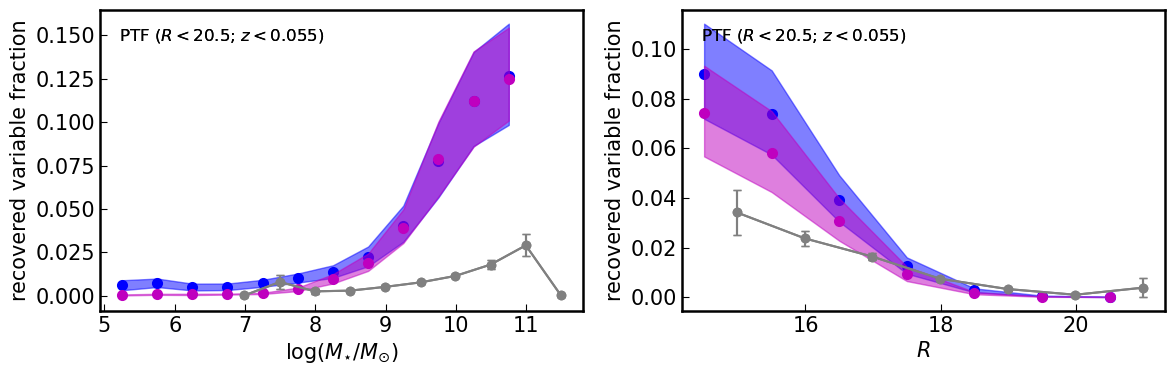

In [51]:
key = 'ptf'
s = samples[key]
nbootstrap = pars[key]['nbootstrap']

labels = {'ptf':r'PTF ($R < 20.5$; $z < 0.055$)', 'lsst':r'LSST ($g < 25.0$; $z < 0.15$)'}
colors = ['b', 'm']

label = labels[key]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.flatten()

for i, seed in enumerate(['dc','popIII']):

    M_BH = s[f'M_BH_draw_{seed}']
    M_BH_all = s[f'M_BH_draw']
    log_M_BH = np.log10(M_BH.value)
    log_M_BH_all = np.log10(M_BH_all.value)

    M_star_all = s[f'M_star_draw']
    log_M_star_all = np.log10(M_star_all.value)

    bins = np.arange(5, 12.5, 0.5)
    M_star = np.log10(s[f'M_star_draw'].value)

    f = np.full([nbootstrap, len(bins)-1], np.nan)

    for j in range(nbootstrap):
        ndraw = int(s['ndraws'][j])
        ndraw_dim = int(np.max(s['ndraws']))
        
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
        mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > 14
        mask_mass = (M_BH[j,:ndraw_dim] > 10**2*u.Msun)
        mask_mass_all = (M_BH_all[j,:ndraw_dim] > 10**2*u.Msun)
        
        bin_count, bin_edges, binnumber = st.binned_statistic(log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat],
                                                              log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat],
                                                              statistic='count', bins=bins)
        bin_count_var, bin_edges, binnumber = st.binned_statistic(log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                                                                  log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                                                                  statistic='count', bins=bins)
        f[j] = bin_count_var/bin_count #*.2

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axs[0].fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0), color=colors[i], alpha=0.5)
    # There are some "simulation" noise here if eta is too large
    axs[0].scatter(bin_centers, np.mean(f, axis=0), lw=2, color=colors[i])
    axs[0].set_ylabel('recovered variable fraction')
    axs[0].set_xlabel(r'$\log(M_{\rm{\star}}/M_{\odot})$')
    #axs[1].set_xlim([6, 11])
    axs[0].text(0.04, 0.90, label, fontsize=12, transform=axs[0].transAxes)
    
    if key == 'ptf':
        from astropy.io import ascii
        dat = ascii.read('bgg20.txt')
        n = [151, 519, 1313, 3237, 7467, 14052, 16367, 3188, 692, 155]
        bgg_m = dat['col1'].data
        bgg_f = dat['col2'].data
        axs[0].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='gray', capsize=3)
        
    
    mag = s[f'm_{band}_{seed}']

    bins = np.arange(14, 22, 1.0)
    M_star = np.log10(s[f'M_star_draw'].value)

    f = np.full([nbootstrap, len(bins)-1], np.nan)

    for j in range(nbootstrap):
        ndraw = int(s['ndraws'][j])
        ndraw_dim = int(np.max(s['ndraws']))
        
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
        mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > 14
        mask_mass = (M_BH[j,:ndraw_dim] > 10**2*u.Msun)
        mask_mass_all = (M_BH_all[j,:ndraw_dim] > 10**2*u.Msun)
                
        bin_count, bin_edges, binnumber = st.binned_statistic(mag[j,:ndraw_dim][mask_mag & mask_sat],
                                                              log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat],
                                                              statistic='count', bins=bins)
        bin_count_var, bin_edges, binnumber = st.binned_statistic(mag[j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                                                                  log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                                                                  statistic='count', bins=bins)
        f[j] = bin_count_var/bin_count
        print(bin_count_var)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axs[1].fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0), color=colors[i], alpha=0.5)
    # There are some "simulation" noise here if eta is too large
    axs[1].scatter(bin_centers, np.mean(f, axis=0), lw=2, color=colors[i])
    axs[1].set_ylabel('recovered variable fraction')
    axs[1].set_xlabel(r'$R$')
    #axs[1].set_xlim([6, 11])
    axs[1].text(0.04, 0.90, label, fontsize=12, transform=axs[1].transAxes)
    
    if key == 'ptf':
        from astropy.io import ascii
        dat = ascii.read('bgg20_2.txt')
        n = [409, 2520, 9881, 20261, 11523, 2159, 259]
        bgg_m = dat['col1'].data
        bgg_f = dat['col2'].data
        axs[1].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='gray', capsize=3)
    
    #axs[1].set_ylim([-0.005, 0.05])

fig.tight_layout()
fig.savefig('varfrac_ptf.pdf', dpi=300)


In [48]:
# Why is the variance so high for the low-mass ones?? not enough bootstrap samples?
# Why i

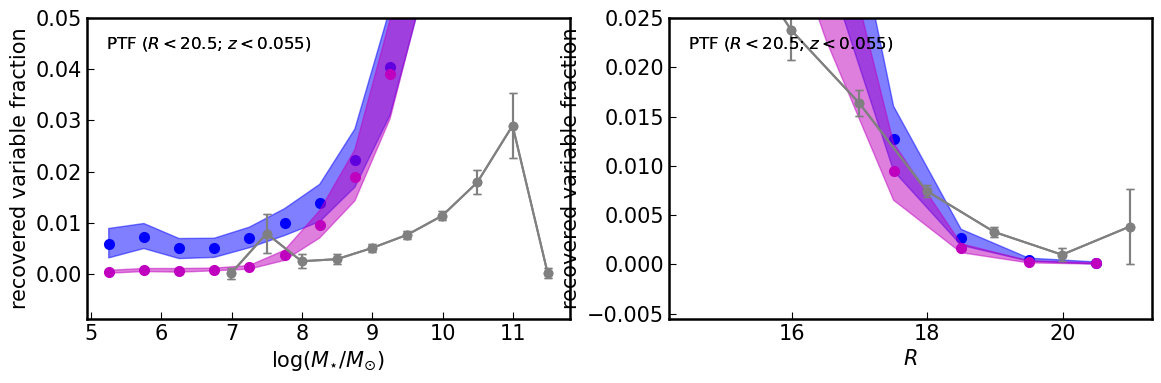

In [52]:
axs[0].set_ylim([None, 0.05])
axs[1].set_ylim([None, 0.025])
fig

### Visualize SED grid

In [ ]:
model.samples.keys()

In [ ]:
band='SDSS_g'

Text(0.5, 0, 'redshift')

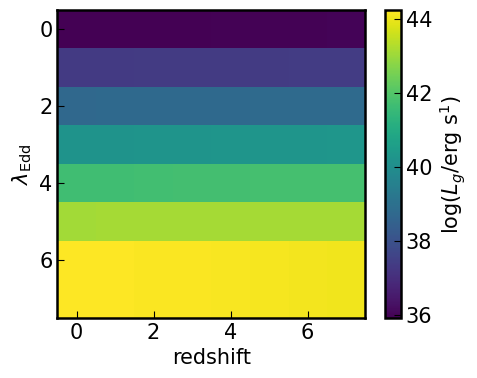

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(model.samples[f'L_{band}_model'][0,:,:].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')


ax.set_ylabel(r'$\lambda_{\rm{Edd}}$')
ax.set_xlabel('redshift')

Text(0.5, 0, '$\\lambda_{\\rm{Edd}}$')

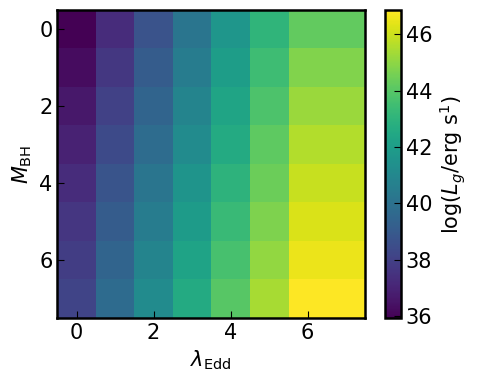

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(model.samples[f'L_{band}_model'][:,:,0].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')

ax.set_ylabel(r'$M_{\rm{BH}}$')
ax.set_xlabel(r'$\lambda_{\rm{Edd}}$')

### Example SEDs

In [32]:
lib = pyphot.get_library()

# if lamb_T has units the Filter object will use those.
#f = pyphot.Filter(lamb_T, T, name='my_filter', dtype='photon', unit='Angstrom') # Import Rubin filters
f = lib['SDSS_g']

0.00701593806109562
39.56530053262444 39.10037054511756
41.56530053530371 41.10037054511756
43.56530053831617 43.10037054511756
45.5653005362672 45.10037054511756


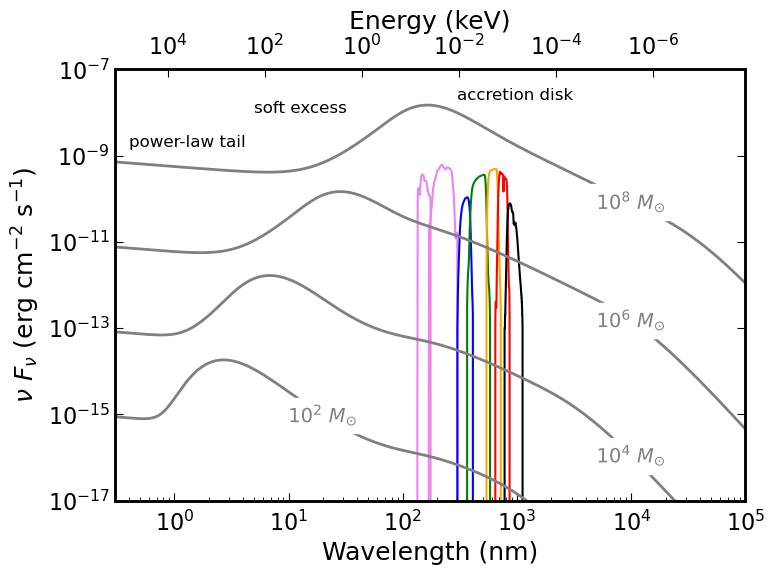

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
model_sed = xspec.Model("optxagnf")

for i, M_BH_i in enumerate(bh_masses):
    
    pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = nuf_nu/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    ax.loglog(wav.value, nuf_nu.value, color='gray', lw=2, label=s)
    ax_top.loglog(energies.value[:-1], sed, alpha=0, lw=2)
    
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)

# Plot bandpasses
colors = ['violet','violet','blue','green','orange','red','black']
bands = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bands):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 1e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)

lines = ax.get_lines()
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,1e4,1e4,1e4]*len(lines))

for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

### Example light curves

In [ ]:
from model import simulate_drw
# Test host diulation
t_rest = np.arange(0, 5000, 1)
# The variable part is measured from quasars
m_var = simulate_drw(np.array([t_rest]).T, np.array([50]), np.array([0]), np.array([18]), np.array([0.5]))
# Now add a host galaxy
m = -2.5*np.log10(10**(-0.4*16) + 10**(-0.4*m_var))
# Now what is the new SF_inft?
print(np.std(m), np.std(m_var))

plt.plot(t_rest, m)

In [ ]:
dm = 0.5
f1 = 10**(-0.4*18)
df = f1*np.log(10)/2.5*dm

f2 = 10**(-0.4*16)

dm_new = 2.5/np.log(10)*df/(f1+f2)

print(dm_new)

In [34]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

tau_drw_Macleod = 10**dat['col8']*u.day
z = dat['col4']

edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge==0) & (Plike-Pnoise>2) & (Plike-Pinf>0.05) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
t = tau_drw_Macleod.to(u.year).value
SF_inf_Macleod = 10**(dat['col9']*(t**0.5))[mask] # log sigma

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

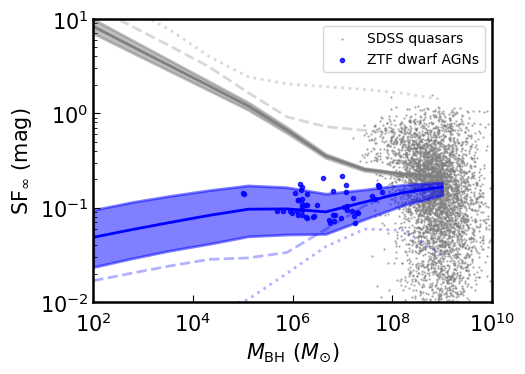

In [37]:
from model import get_AGN_flux, draw_SFinf

fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux)

size = 200
M_BH = np.logspace(2, 9, 10)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001] #, 1e-4, 1e-5, 1e-6, 1e-7]

z_ex = 0.007 # ~30 Mpc
f_host = 0.2 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.4 # 0.2 - 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}

for lambda_Edd in lambda_Edds:

    M_band_AGN, m_band_AGN, L_band_AGN, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]), np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)

# Data
ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, color='gray', alpha=0.8, label='SDSS quasars', zorder=-10)
ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('SFinf.pdf', dpi=300)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

lambda_Edd = 0.1

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen
M_i_AGN = M_i_AGN + 0.5964 # assuming an alpha_nu =-0.5 contiuum spectrum

ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='Done et al. 2012')
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$') # Fake line
ax.fill_between(M_BH, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)
ax.tick_params(axis='x', which='major', pad=7)

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)
fig.tight_layout()
fig.savefig('Mi.pdf', dpi=300)

In [ ]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.5,  g_minus_i=0.8, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau2(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return simulate_drw2(t_rest, tau, z, m_band_AGN, SFinf)

In [ ]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

nex = len(bh_masses)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)

M_BH = [1e2, 1e4, 1e6, 1e8]*u.Msun

for i, M_BH_i in enumerate(M_BH):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BH) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
fig.savefig('lc_examples.pdf', dpi=300)